In [1]:
from pathlib import Path
import sys

ROOT = next((p for p in [Path.cwd(), *Path.cwd().parents] if (p / "scripts").is_dir() or (p / "data").is_dir()), None)
if ROOT is None:
    raise RuntimeError("Repo-Root not found (expected folder 'scripts' or 'data').")
sys.path.insert(0, str(ROOT))

results = [] #results für svm speichern 

DATA_DIR = ROOT / "data"
DRF_DIRS_BIG = [(DATA_DIR / "drf_big" / f"precomputed_drf_{m}", m) for m in ("edge", "vertex", "sp")]
DRF_DIRS_SMALL = [(DATA_DIR / "drf_small" / f"precomputed_drf_{m}", m) for m in ("edge", "vertex", "sp")]
ITS_DIRS_BIG = [(DATA_DIR / "its_big" / f"precomputed_its_{m}", m) for m in ("edge", "vertex", "sp")]
ITS_DIRS_SMALL = [(DATA_DIR / "its_small" / f"precomputed_its_{m}", m) for m in ("edge", "vertex", "sp")]

# WP3 — Kernel-based Classification (SVM)

This notebook implements kernel inner products on precomputed hashed feature sets and runs
SVM classification for DRF–WL and ITS–WL across different feature types (vertex/edge/shortest-path),
dataset sizes, numbers of classes, and train/test splits.

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "vscode"
import pickle
from pathlib import Path
from collections import Counter

#local imports
from scripts.wp3.wp3_loader import (
    load_precomputed_features,
    available_subset_ids,
)

from scripts.wp3.wp3_kernel import (
    compute_kernel_matrix,
    kernel_multiset_intersection,
    kernel_matrix_stats,
)

from scripts.wp3.wp3_svm import (
    run_SVM,
    train_svm_from_datasets,
    ResultLogger,
)

from scripts.wp3.wp3_plots import (
    fig2_style_svm_from_kernel, 
    plot_experiment_dashboard,
    plot_heatmaps_by_k,
    plot_difference_heatmap,
    plot_drf_minus_its_bar,
    plot_drf_vs_its_dots,
    plot_accuracy_by_k,
)

from scripts.wp3.wp3_subset_handler import (
    make_soft_shared_k_classes_config,
    safe_subset_ids
)

from scripts.wp3.wp3_error_handling import (
    debug_pkl_basic, debug_pkl_empties, debug_dir_summary, debug_find_nonzero_kernel_pair, debug_find_nonempty_pair,
    )

logger = ResultLogger() #zum sichern der SVM results


## 1) Paths to precomputed feature directories

We load precomputed feature representations (stored as `.pkl`) for:
- DRF–WL: reactant/product difference features
- ITS–WL: features from the ITS reaction graph
Each representation is available for three feature modes: vertex, edge, shortest-path.

### Load DRF–WL Features
Load precomputed DRF–WL feature sets and reaction class labels for kernel-based classification.

In [3]:

X_drf, y_drf = {}, {}
for path, mode in DRF_DIRS_SMALL:  # ACHTUNG: Reihenfolge (path, mode)
    assert path.exists(), f"Pfad nicht gefunden: {path}"
    X, y = load_precomputed_features(path, feature_key="drf_wl")
    X_drf[mode] = X
    y_drf[mode] = y
    print(f"\nLoaded DRF features ({mode}) from {path}")
    print("Number of reactions:", len(X))
    print("Number of classes:", len(set(y)))


Loaded DRF features (edge) from c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels\data\drf_small\precomputed_drf_edge
Number of reactions: 50000
Number of classes: 50

Loaded DRF features (vertex) from c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels\data\drf_small\precomputed_drf_vertex
Number of reactions: 50000
Number of classes: 50

Loaded DRF features (sp) from c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels\data\drf_small\precomputed_drf_sp
Number of reactions: 50000
Number of classes: 50


### Load ITS–WL Features
Load precomputed ITS–WL feature sets and reaction class labels derived from the ITS graph.

In [4]:
X_its = {}
y_its = {}
for path, mode in ITS_DIRS_SMALL:  # ACHTUNG: Reihenfolge (path, mode)
    assert path.exists(), f"Pfad nicht gefunden: {path}"
    X, y = load_precomputed_features(path, feature_key="its_wl")
    X_its[mode] = X
    y_its[mode] = y
    print(f"\nLoaded ITS features ({mode}) from {path}")
    print("Number of reactions:", len(X))
    print("Number of classes:", len(set(y)))



Loaded ITS features (edge) from c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels\data\its_small\precomputed_its_edge
Number of reactions: 50000
Number of classes: 50

Loaded ITS features (vertex) from c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels\data\its_small\precomputed_its_vertex
Number of reactions: 50000
Number of classes: 50

Loaded ITS features (sp) from c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels\data\its_small\precomputed_its_sp
Number of reactions: 50000
Number of classes: 50


The output confirms that all precomputed DRF–WL feature representations
(edge, vertex, and shortest-path) were loaded successfully. Each representation
contains the full dataset of 50,000 reactions across 50 reaction classes,
providing a consistent basis for kernel computation and classification.

## 2) Kernel inner product on hash sets

The lab definition reduces all kernels to counting common elements of two hashed feature sets.
Given two reactions with feature hash sets \(S_G, S_H\), the kernel is:
\[
k(G,H) = |S_G \cap S_H|
\]

Our precomputed features are stored as Counters. For the required hashset kernel, we use the Counter keys.

### Kernel sanity check (DRF–WL)

We verify that the multiset kernel produces meaningful similarities on the precomputed DRF–WL feature multisets.  
Self-similarity \(k(x,x)\) is clearly positive, and different reactions can still share a non-zero overlap, indicating common reaction-change patterns captured by DRF–WL.

In [5]:
mode = "edge"
X = X_its[mode]   # oder X_drf[mode]

debug_find_nonempty_pair(X)
debug_find_nonzero_kernel_pair(X, kernel_multiset_intersection)

Found non-empty pair at: 0 1
Sizes: 82 35
Found non-zero kernel at: 0 1 value: 8


(0, 1, 8)

### Kernel Matrix Construction

To apply kernel-based classification, the pairwise similarities between all reactions are computed and stored in a kernel matrix. Each entry \(K_{ij}\) represents the multiset kernel value between reactions \(i\) and \(j\). This matrix serves as the direct input for training a Support Vector Machine with a precomputed kernel.

### DRF–WL Kernel Matrix

This heatmap visualizes the DRF–WL edge kernel for a subset of reactions.
The diagonal shows self-similarity, while most off-diagonal values are zero due to the sparsity of DRF features, which encode only reaction-specific changes.
Non-zero entries indicate reactions with similar bond-change patterns.

In [6]:
modes = ["edge", "vertex", "sp"]
n = 200

for mode in modes:
    X_mode = X_drf[mode]  
    y_mode = y_drf[mode]

    K_drf = compute_kernel_matrix(X_mode[:n])
    stats = kernel_matrix_stats(K_drf)

    #print(f"\n[DRF–WL | {mode} | n={n}] stats:", stats)

    fig = px.imshow(
        K_drf,
        title=f"Kernel Matrix Heatmap (DRF–WL {mode}, n={n})",
        aspect="auto",
    )
    fig.show()

**Figure (DRF–WL):** Kernel matrix heatmap using the DRF–WL kernel.
Diagonal entries show self-similarity, while most off-diagonal values are near zero due to the sparsity of reaction-only features.
Non-zero entries indicate reactions with similar bond-change patterns.

#### Error Handling

In [7]:
path = DATA_DIR / "drf_small/precomputed_drf_edge"
debug_pkl_basic(path, feature_key="drf_wl")
debug_pkl_empties(path, feature_key="drf_wl")
debug_dir_summary(path, feature_key="drf_wl")

Inspecting: c:\Users\OPokrovskaja\Documents\praktikum_graphen\reaction-kernels\data\drf_small\precomputed_drf_edge\subset_001.reaction_features_drf_wl_h3_edge.pkl
Keys: dict_keys(['meta', 'rsmi', 'classes', 'drf_wl', 'errors'])
n_errors: 0
First error: []
First feature: <class 'collections.Counter'> Counter({'ba69450099be1228e55119b644917475': 2, '9b809fa431672ccefbfe5b6d0402de51': 2, '86673f02a9bba3113b35f611fee08fab': 1, 'cb971224630e1fa84d2af5eea097fd26': 1, '119fcc403eca81c58aee0a625c395fe8': 1, 'e11f3902c40931c8135357648e383a14': 1, '34be2e7bb02c994c02c30ecd3c73a525': 1, 'dbacacd83403b2a6183294a013ec6171': 1, '492ca8068eefba983c156ad6f573064e': 1, '0799416cdb8b81412f954f68f075db28': 1, 'a1059605d4ac281dd427bcc72cec68e9': 1, 'a4cc4d804da94386fbfb2fa78e478175': 1, 'aafefb781d912d2c2774513565317a13': 1, '212530ddfae31a47ae3e0f628a5c1259': 1, 'c8519db4f81dd9a7b386a3d576a076d5': 1, 'd6e4a99e1570c9b34930187105eacf45': 1, 'f71f8a3ff4290e9827a4a463e3628c9e': 1, 'f7950a2e4ca791926605076f66

### ITS–WL Kernel Matrix 

The ITS–WL kernel matrix shows a much denser similarity structure than DRF–WL.
This is expected, since ITS encodes the full combined structure of reactants and products, including unchanged molecular context.
As a result, many reactions share common substructures, leading to higher off-diagonal similarities and a less sparse kernel.

In [ ]:
modes = ["edge", "vertex", "sp"]
n = 200

for mode in modes:
    X_mode = X_its[mode]  
    y_mode = y_its[mode]

    K_its = compute_kernel_matrix(X_mode[:n])
    stats = kernel_matrix_stats(K_its)

    #print(f"\n[ITS–WL | {mode} | n={n}] stats:", stats)

    fig = px.imshow(
        K_its,
        title=f"Kernel Matrix Heatmap (ITS–WL {mode}, n={n})",
        aspect="auto",
    )
    fig.show()

**Figure (ITS–WL):** Kernel matrix heatmap using the ITS–WL edge kernel.
The matrix is denser than DRF–WL, since ITS encodes the full molecular context of reactants and products.
Off-diagonal entries therefore reflect shared structural motifs beyond the reaction center.

### Comparison of DRF–WL and ITS–WL Kernel Matrices

The DRF–WL and ITS–WL kernel matrices reveal complementary notions of reaction similarity.
DRF–WL focuses exclusively on reaction-specific changes by computing the symmetric difference between reactant and product features.
As a result, the corresponding kernel matrix is sparse, with non-zero similarities only for reactions that share similar bond-change patterns.

In contrast, ITS–WL operates on the Imaginary Transition State graph, which encodes the full structural context of both reactants and products.
This leads to a denser kernel matrix, as reactions may share common substructures even if their reaction centers differ.

Consequently, DRF–WL provides a highly selective notion of similarity tailored to reaction mechanisms,
whereas ITS–WL captures broader structural resemblance between reactions.
Both representations are therefore suitable for different aspects of reaction classification.

**Figure:** Kernel matrix heatmaps for DRF–WL (bottom) and ITS–WL (top) using edge-based Weisfeiler–Lehman features.
Each entry \(K_{ij}\) corresponds to the multiset intersection between the feature representations of reactions \(i\) and \(j\).
The diagonal indicates self-similarity, while off-diagonal values reflect shared structural or reaction-specific features.
DRF–WL produces a sparse kernel emphasizing reaction changes, whereas ITS–WL yields a denser kernel capturing overall structural similarity.

In [9]:
import numpy as np
import plotly.express as px

def upper_triangle_values(K):
    i, j = np.triu_indices(K.shape[0], k=1)  # nur i<j, ohne Diagonale
    return K[i, j]

vals_drf = upper_triangle_values(K_drf)
vals_its = upper_triangle_values(K_its)

fig = px.histogram(
    x=[vals_drf, vals_its],
    nbins=60,
    opacity=0.55,
    title="DRF vs ITS: Distribution of Kernel Similarities (upper triangle)",
    labels={"value": "Kernel value", "variable": "Kernel"},
)

fig.data[0].name = "DRF–WL"
fig.data[1].name = "ITS–WL"
fig.show()

**Figure:** Distribution of off-diagonal kernel values for DRF–WL and ITS–WL.
DRF–WL produces a highly sparse similarity distribution with many zero entries, reflecting its focus on reaction-specific changes.
In contrast, ITS–WL yields a broader distribution, capturing shared structural context between reactions.

# SVM Classification with a Custom Reaction Kernel
An SVM classifier was trained using a custom multiset-intersection kernel on reaction features.
Because the kernel compares pairs of reactions directly, the kernel matrix was precomputed and used with `kernel="precomputed"`.
This setup allows a fair and consistent comparison between DRF–WL and ITS–WL using the same SVM configuration.


To systematically evaluate kernel variants, we run the same SVM setup for each feature mode separately.
This yields comparable accuracies for edge-, vertex-, and shortest-path-based WL representations without mixing feature spaces.

##  SVM Classification with the Small Data Set

In [10]:
DRF_DIRS_BIG = {
    "edge":   DATA_DIR / "drf_big" / "precomputed_drf_edge",
    "vertex": DATA_DIR / "drf_big" / "precomputed_drf_vertex",
    "sp":     DATA_DIR / "drf_big" / "precomputed_drf_sp",
}

DRF_DIRS_SMALL = {
    "edge":   DATA_DIR / "drf_small" / "precomputed_drf_edge",
    "vertex": DATA_DIR / "drf_small" / "precomputed_drf_vertex",
    "sp":     DATA_DIR / "drf_small" / "precomputed_drf_sp",
}

ITS_DIRS_BIG = {
    "edge":   DATA_DIR / "its_big" / "precomputed_its_edge",
    "vertex": DATA_DIR / "its_big" / "precomputed_its_vertex",
    "sp":     DATA_DIR / "its_big" / "precomputed_its_sp",
}

ITS_DIRS_SMALL = {
    "edge":   DATA_DIR / "its_small" / "precomputed_its_edge",
    "vertex": DATA_DIR / "its_small" / "precomputed_its_vertex",
    "sp":     DATA_DIR / "its_small" / "precomputed_its_sp",
}

In [ ]:
# =========================
# Global SVM settings
# =========================
C = 1.0
seed = 42
test_sizes = [0.2]        # baseline
n_values = [600]          # baseline

Option 1 config:
{'name': 'opt1_soft_k2_min10_scan50_its', 'subset_ids': [10, 787], 'target_classes': ['3.4.1', '6.3.7'], 'k': 2, 'min_per_class': 10, 'ref_scan': 50, 'ref_side': 'its', 'n_common_available': 834}
Chosen subset_ids: [10, 787]
Number of chosen subsets: 2


### 1) Baseline Comparison: DRF–WL vs ITS–WL

In this experiment, DRF–WL and ITS–WL kernels are compared under identical conditions to provide a fair baseline.
All parameters are fixed (feature mode, dataset size, train/test split, and SVM regularization), and only the
graph representation differs. This allows us to directly assess the impact of reaction-based versus structure-based
graph representations on classification performance.

In [12]:
# =========================
# Section 1: Baseline (k=1 vs k=2)
# =========================
# results sammelt alle Runs

for k in [1, 2]:
    opt_k = make_soft_shared_k_classes_config(
        drf_edge_dir=DRF_DIRS_SMALL["edge"],
        its_edge_dir=ITS_DIRS_SMALL["edge"],
        k=k,
        take_subsets=30,
        min_per_class=5,
        ref_scan=180,
    )
    subset_ids = safe_subset_ids(opt_k["subset_ids"], DRF_DIRS_SMALL["edge"], ITS_DIRS_SMALL["edge"], take=20)

    print(f"\n[S4 | k={k}] using {len(subset_ids)} subsets:", subset_ids[:10], "..." if len(subset_ids)>10 else "")

    # DRF edge
    res = train_svm_from_datasets(
        precomp_dir=DRF_DIRS_SMALL["edge"],
        feature_key="drf_wl",
        subset_ids=subset_ids,
        n=600, test_size=0.2, C=C, seed=seed,
        verbose=False,
    )
    logger.add_result("S1_baseline", "DRF–WL", "edge", 600, 0.2, C, seed, res, subset_ids=subset_ids, k=k)

    # ITS edge
    res = train_svm_from_datasets(
        precomp_dir=ITS_DIRS_SMALL["edge"],
        feature_key="its_wl",
        subset_ids=subset_ids,
        n=600, test_size=0.2, C=C, seed=seed,
        verbose=False,
    )
    logger.add_result("S1_baseline", "ITS–WL", "edge", 600, 0.2, C, seed, res, subset_ids=subset_ids, k=k)

df_results = pd.DataFrame(logger.results)
df_results[df_results["tag"]=="S1_baseline"][["kernel","mode","k","n","test_size","accuracy","subset_ids"]].sort_values(["k","kernel"])


[S4 | k=1] using 30 subsets: [1, 10, 13, 37, 42, 44, 55, 64, 70, 80] ...

[S4 | k=2] using 20 subsets: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] ...


kernel  mode  k    n  test_size  accuracy  \
0  DRF–WL  edge  1  600        0.2  0.750000   
1  ITS–WL  edge  1  600        0.2  0.566667   
2  DRF–WL  edge  2  600        0.2  0.808333   
3  ITS–WL  edge  2  600        0.2  0.600000   

                                          subset_ids  
0  [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  
1  [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...

### 2) Feature Mode Comparison

This section evaluates the influence of different feature extraction modes on classification accuracy.
Edge-, vertex-, and shortest-path-based WL features are compared while keeping all other parameters fixed.
The experiment highlights which structural information is most informative for reaction classification.

In [13]:
# =========================
# Section 2: Modes (edge/vertex/sp)
# =========================

for k in [1, 2]:
    opt_k = make_soft_shared_k_classes_config(
        drf_edge_dir=DRF_DIRS_SMALL["edge"],
        its_edge_dir=ITS_DIRS_SMALL["edge"],
        k=k,
        take_subsets=30,
        min_per_class=5,
        ref_scan=180,
    )
    subset_ids = safe_subset_ids(opt_k["subset_ids"], DRF_DIRS_SMALL["edge"], ITS_DIRS_SMALL["edge"], take=20)

    print(f"\n[S2 | k={k}] using {len(subset_ids)} subsets")

    for mode in ["edge", "vertex", "sp"]:
        # DRF
        res = train_svm_from_datasets(
            precomp_dir=DRF_DIRS_SMALL[mode],
            feature_key="drf_wl",
            subset_ids=subset_ids,
            n=600, test_size=0.2, C=C, seed=seed,
            verbose=False,
        )
        logger.add_result("S2_modes", "DRF–WL", mode, 600, 0.2, C, seed, res, subset_ids=subset_ids, k=k)

        # ITS
        res = train_svm_from_datasets(
            precomp_dir=ITS_DIRS_SMALL[mode],
            feature_key="its_wl",
            subset_ids=subset_ids,
            n=600, test_size=0.2, C=C, seed=seed,
            verbose=False,
        )
        logger.add_result("S2_modes", "ITS–WL", mode, 600, 0.2, C, seed, res, subset_ids=subset_ids, k=k)

df_results = pd.DataFrame(logger.results)
df_results[df_results["tag"]=="S2_modes"][["kernel","mode","k","n","accuracy","subset_ids"]].sort_values(["k","kernel","mode"])


[S2 | k=1] using 30 subsets

[S2 | k=2] using 20 subsets


kernel    mode  k    n  accuracy  \
4   DRF–WL    edge  1  600  0.750000   
8   DRF–WL      sp  1  600  0.450000   
6   DRF–WL  vertex  1  600  0.850000   
5   ITS–WL    edge  1  600  0.566667   
9   ITS–WL      sp  1  600  0.450000   
7   ITS–WL  vertex  1  600  0.616667   
10  DRF–WL    edge  2  600  0.808333   
14  DRF–WL      sp  2  600  0.450000   
12  DRF–WL  vertex  2  600  0.850000   
11  ITS–WL    edge  2  600  0.600000   
15  ITS–WL      sp  2  600  0.308333   
13  ITS–WL  vertex  2  600  0.641667   

                                           subset_ids  
4   [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  
8   [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  
6   [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  
5   [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  
9   [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  
7   [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  
10  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
14  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
12  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
13  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...

### 3) Effect of Dataset Size

To study the scalability and robustness of the kernel-based approach, the dataset size is varied while
keeping the kernel configuration constant. This experiment shows how classification performance changes
as more training data becomes available.

In [14]:
# =========================
# Section 3: Size sweep (n)
# =========================
# WICHTIG: alle Subsets verwenden
subset_ids = None   # <-- DAS ist der richtige Ort

print("\n[Section 3] Using ALL subsets (subset_ids=None)")

for k in [1, 2]:
    opt_k = make_soft_shared_k_classes_config(
        drf_edge_dir=DRF_DIRS_SMALL["edge"],
        its_edge_dir=ITS_DIRS_SMALL["edge"],
        k=k,
        take_subsets=30,
        min_per_class=5,
        ref_scan=180,
    )
    subset_ids = safe_subset_ids(opt_k["subset_ids"], DRF_DIRS_SMALL["edge"], ITS_DIRS_SMALL["edge"], take=20)

    print(f"\n[S3 | k={k}] using {len(subset_ids)} subsets")

    for n in [200, 600, 1200]:
        # DRF edge
        res = train_svm_from_datasets(
            precomp_dir=DRF_DIRS_SMALL["edge"],
            feature_key="drf_wl",
            subset_ids=subset_ids,
            n=n, test_size=0.2, C=C, seed=seed,
            verbose=False,
        )
        logger.add_result("S3_size", "DRF–WL", "edge", n, 0.2, C, seed, res, subset_ids=subset_ids, k=k)

        # ITS edge
        res = train_svm_from_datasets(
            precomp_dir=ITS_DIRS_SMALL["edge"],
            feature_key="its_wl",
            subset_ids=subset_ids,
            n=n, test_size=0.2, C=C, seed=seed,
            verbose=False,
        )
        logger.add_result("S3_size", "ITS–WL", "edge", n, 0.2, C, seed, res, subset_ids=subset_ids, k=k)

# Ergebnisse anzeigen
df_results = pd.DataFrame(logger.results)
df_results[df_results["tag"]=="S3_size"][
    ["kernel", "mode", "n", "accuracy"]
].sort_values(["kernel", "n"])


[Section 3] Using ALL subsets (subset_ids=None)

[S3 | k=1] using 30 subsets

[S3 | k=2] using 20 subsets


kernel  mode     n  accuracy
16  DRF–WL  edge   200  0.850000
22  DRF–WL  edge   200  0.725000
18  DRF–WL  edge   600  0.750000
24  DRF–WL  edge   600  0.808333
20  DRF–WL  edge  1200  0.762500
26  DRF–WL  edge  1200  0.804167
17  ITS–WL  edge   200  0.675000
23  ITS–WL  edge   200  0.625000
19  ITS–WL  edge   600  0.566667
25  ITS–WL  edge   600  0.600000
21  ITS–WL  edge  1200  0.625000
27  ITS–WL  edge  1200  0.587500

### 4) Effect of Train/Test Split

This experiment investigates the sensitivity of the SVM classifier to different train/test splits.
By increasing the proportion of test data, we assess the stability and generalization capability of the
kernel-based model.

In [15]:
# =========================
# Section 4: Train/Test split sweep
# =========================

for k in [1, 2]:
    opt_k = make_soft_shared_k_classes_config(
        drf_edge_dir=DRF_DIRS_SMALL["edge"],
        its_edge_dir=ITS_DIRS_SMALL["edge"],
        k=k,
        take_subsets=30,
        min_per_class=5,
        ref_scan=180,
    )

    subset_ids = safe_subset_ids(opt_k["subset_ids"], DRF_DIRS_SMALL["edge"], ITS_DIRS_SMALL["edge"], take=20)
    print(f"\n[S7 | k={k}] using {len(subset_ids)} subsets:", subset_ids[:10], "..." if len(subset_ids)>10 else "")

    for ts in [0.1, 0.2, 0.3, 0.4]:
        # DRF edge
        res = train_svm_from_datasets(
            precomp_dir=DRF_DIRS_SMALL["edge"],
            feature_key="drf_wl",
            subset_ids=subset_ids,
            n=n, test_size=ts, C=C, seed=seed,
            verbose=False,
        )
        logger.add_result("S4_split", "DRF–WL", "edge", n, ts, C, seed, res, subset_ids=subset_ids, k=k)

        # ITS edge
        res = train_svm_from_datasets(
            precomp_dir=ITS_DIRS_SMALL["edge"],
            feature_key="its_wl",
            subset_ids=subset_ids,
            n=n, test_size=ts, C=C, seed=seed,
            verbose=False,
        )
        logger.add_result("S4_split", "ITS–WL", "edge", n, ts, C, seed, res, subset_ids=subset_ids, k=k)

df_results = pd.DataFrame(logger.results)

# Section 7 anzeigen (nicht S4!)
df_results[df_results["tag"]=="S4_split"][["kernel","k","mode","n","test_size","accuracy","subset_ids"]].sort_values(["k","kernel","test_size"])


[S7 | k=1] using 30 subsets: [1, 10, 13, 37, 42, 44, 55, 64, 70, 80] ...

[S7 | k=2] using 20 subsets: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] ...


kernel  k  mode     n  test_size  accuracy  \
28  DRF–WL  1  edge  1200        0.1  0.758333   
30  DRF–WL  1  edge  1200        0.2  0.762500   
32  DRF–WL  1  edge  1200        0.3  0.733333   
34  DRF–WL  1  edge  1200        0.4  0.722917   
29  ITS–WL  1  edge  1200        0.1  0.608333   
31  ITS–WL  1  edge  1200        0.2  0.625000   
33  ITS–WL  1  edge  1200        0.3  0.600000   
35  ITS–WL  1  edge  1200        0.4  0.575000   
36  DRF–WL  2  edge  1200        0.1  0.800000   
38  DRF–WL  2  edge  1200        0.2  0.804167   
40  DRF–WL  2  edge  1200        0.3  0.777778   
42  DRF–WL  2  edge  1200        0.4  0.768750   
37  ITS–WL  2  edge  1200        0.1  0.625000   
39  ITS–WL  2  edge  1200        0.2  0.587500   
41  ITS–WL  2  edge  1200        0.3  0.536111   
43  ITS–WL  2  edge  1200        0.4  0.487500   

                                           subset_ids  
28  [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  
30  [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  
32  [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  
34  [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  
29  [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  
31  [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  
33  [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  
35  [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  
36  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
38  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
40  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
42  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
37  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
39  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
41  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
43  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...

## Summary of Classification Results

This section summarizes the classification results obtained across all experiments.
The comparison highlights the strengths and limitations of different kernel representations, feature modes,
and dataset configurations, and provides an overall assessment of the kernel-based reaction classification approach.

Rows: 44


tag  kernel    mode    n  test_size    C  seed  accuracy  \
0  S1_baseline  DRF–WL    edge  600        0.2  1.0    42  0.750000   
1  S1_baseline  ITS–WL    edge  600        0.2  1.0    42  0.566667   
2  S1_baseline  DRF–WL    edge  600        0.2  1.0    42  0.808333   
3  S1_baseline  ITS–WL    edge  600        0.2  1.0    42  0.600000   
4     S2_modes  DRF–WL    edge  600        0.2  1.0    42  0.750000   
5     S2_modes  ITS–WL    edge  600        0.2  1.0    42  0.566667   
6     S2_modes  DRF–WL  vertex  600        0.2  1.0    42  0.850000   
7     S2_modes  ITS–WL  vertex  600        0.2  1.0    42  0.616667   
8     S2_modes  DRF–WL      sp  600        0.2  1.0    42  0.450000   
9     S2_modes  ITS–WL      sp  600        0.2  1.0    42  0.450000   

                                          subset_ids  k  
0  [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  1  
1  [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  1  
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  2  
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  2  
4  [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  1  
5  [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  1  
6  [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  1  
7  [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  1  
8  [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  1  
9  [1, 10, 13, 37, 42, 44, 55, 64, 70, 80, 83, 11...  1


Kernel counts (normalized):
kernel_norm
DRF-WL    22
ITS-WL    22
Name: count, dtype: int64

Combinations missing DRF or ITS: 22


tag          mode    k  n     test_size
S1_baseline  edge    1  600   0.2          {DRF-WL, ITS-WL}
                     2  600   0.2          {DRF-WL, ITS-WL}
S2_modes     edge    1  600   0.2          {DRF-WL, ITS-WL}
                     2  600   0.2          {DRF-WL, ITS-WL}
             sp      1  600   0.2          {DRF-WL, ITS-WL}
                     2  600   0.2          {DRF-WL, ITS-WL}
             vertex  1  600   0.2          {DRF-WL, ITS-WL}
                     2  600   0.2          {DRF-WL, ITS-WL}
S3_size      edge    1  200   0.2          {DRF-WL, ITS-WL}
                        600   0.2          {DRF-WL, ITS-WL}
                        1200  0.2          {DRF-WL, ITS-WL}
                     2  200   0.2          {DRF-WL, ITS-WL}
                        600   0.2          {DRF-WL, ITS-WL}
                        1200  0.2          {DRF-WL, ITS-WL}
S4_split     edge    1  1200  0.1          {DRF-WL, ITS-WL}
                              0.2          {DRF-WL, ITS-WL}


Empty DataFrame
Columns: [tag, kernel, mode, k, n, test_size, accuracy, subset_ids]
Index: []

Empty DataFrame
Columns: [tag, kernel, mode, k, n, test_size, acc_mean, acc_std, runs]
Index: []

Showing: heatmap_kernel_mode


Showing: acc_vs_n_with_bands


Showing: diff_heatmap_drf_minus_its


{'class_a': np.str_('2.1.1'), 'class_b': np.str_('6.3.7'), 'n_samples': 56}


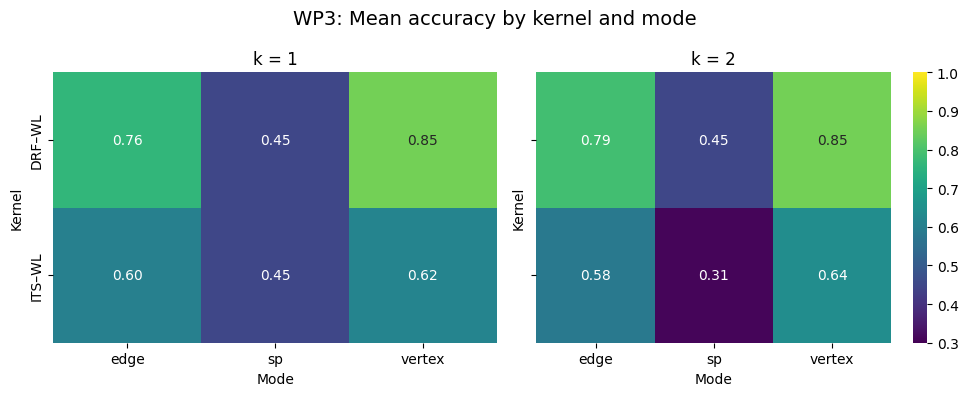

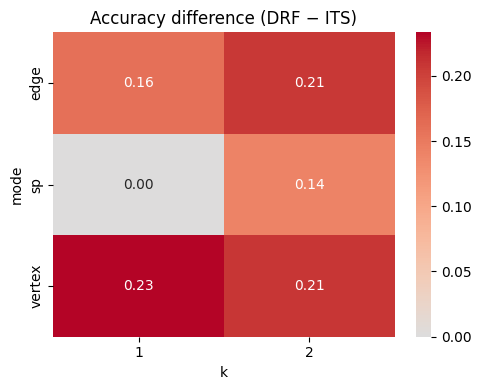

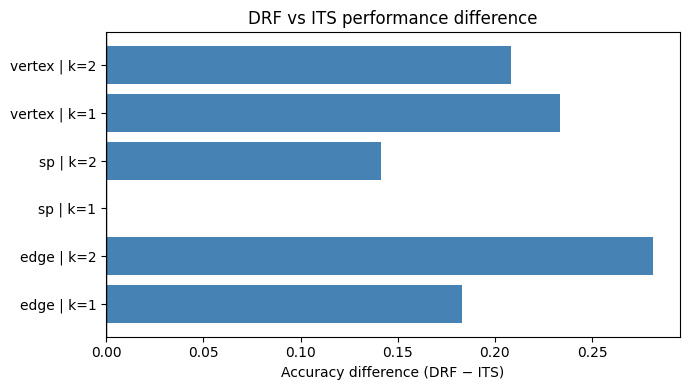

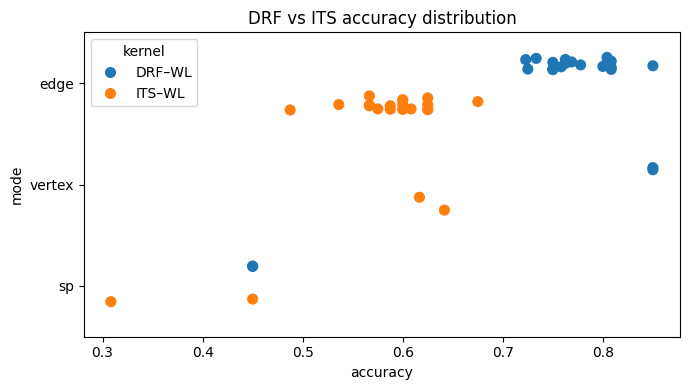

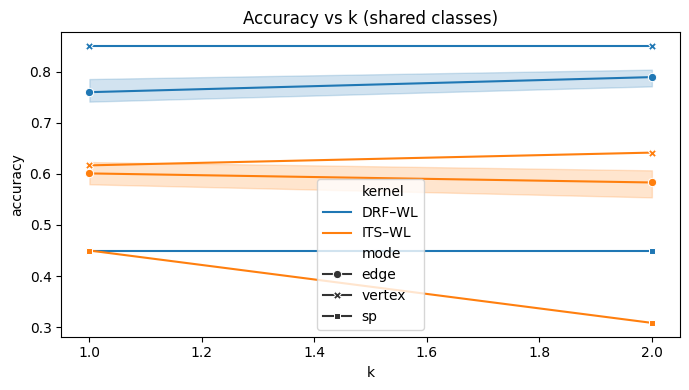

In [16]:
# =========================
# Section 8: Summary + Plots
# =========================

import numpy as np
import pandas as pd

# -------------------------
# 8.1 Build results DataFrame
# -------------------------
df_results = pd.DataFrame(logger.results).copy()

print("Rows:", len(df_results))
display(df_results.head(10))

# Ensure clean dtypes (helps grouping/plots)
for col in ["k", "n", "seed"]:
    if col in df_results.columns:
        df_results[col] = pd.to_numeric(df_results[col], errors="coerce")

if "test_size" in df_results.columns:
    df_results["test_size"] = pd.to_numeric(df_results["test_size"], errors="coerce")

# Normalize kernel name for comparisons (DRF/ITS)
df_results["kernel_norm"] = (
    df_results["kernel"].astype(str).str.upper()
    .str.replace("–", "-", regex=False)
)

print("\nKernel counts (normalized):")
print(df_results["kernel_norm"].value_counts())

# -------------------------
# 8.2 Sanity: do we have DRF and ITS for same setting?
# -------------------------
group_cols = ["tag", "mode", "k", "n", "test_size"]

present = (
    df_results.groupby(group_cols)["kernel_norm"]
    .apply(lambda s: set(s))
)

missing_pairs = present[~present.apply(lambda u: {"DRF", "ITS"}.issubset(u))]

print("\nCombinations missing DRF or ITS:", len(missing_pairs))
if len(missing_pairs) > 0:
    display(missing_pairs.head(20))

# -------------------------
# 8.3 Quick summary table
# -------------------------
SHOW_TAGS = ["S4_baseline", "S5_modes", "S6_size", "S7_split"]

summary = (
    df_results[df_results["tag"].isin(SHOW_TAGS)]
    [["tag","kernel","mode","k","n","test_size","accuracy","subset_ids"]]
    .sort_values(["tag","k","kernel","mode","n","test_size"])
)

display(summary)

# Optional: mean/std across seeds (if you ran multiple seeds)
agg = (
    df_results[df_results["tag"].isin(SHOW_TAGS)]
    .groupby(["tag","kernel","mode","k","n","test_size"], as_index=False)
    .agg(acc_mean=("accuracy","mean"), acc_std=("accuracy","std"), runs=("accuracy","size"))
    .sort_values(["tag","k","kernel","mode","n","test_size"])
)
display(agg)

# -------------------------
# 8.4 Dashboard plots (your helper)
# -------------------------
figs = plot_experiment_dashboard(df_results, title_prefix="WP3 (k=1 vs k=2)")

# show only the ones that exist (prevents KeyError)
for name, fig in figs.items():
    print("Showing:", name)
    fig.show()

# -------------------------
# 8.5 Fig-2 style plot (needs matching y length!)
# -------------------------
nK = K_drf.shape[0]
y_small = np.asarray(y)[:nK]  # MUST match K rows

fig, info = fig2_style_svm_from_kernel(
    K_drf,
    y_small,
    C=1.0,
    n_points_grid=250,
    seed=42,
    title=f"DRF–WL edge | Fig-2 style (n={nK})",
)
print(info)
fig.show()

# -------------------------
# 8.6 Extra comparison plots (only call if your funcs exist)
# -------------------------
# These usually expect df_results with k present
if "k" in df_results.columns and df_results["k"].notna().any():
    plot_heatmaps_by_k(df_results)
    plot_difference_heatmap(df_results)
    plot_drf_minus_its_bar(df_results)
    plot_drf_vs_its_dots(df_results)
    plot_accuracy_by_k(df_results)
else:
    print("[WARN] df_results has no k values -> skipping k-based plots.")

### Fig-2-Style SVM Visualization (Kernel Space → 2D)

To make the SVM decision boundary interpretable, we project the **precomputed kernel matrix** into 2D using **KernelPCA**.
On this 2D embedding we train a **linear SVM** and visualize:

- **Scatter + support vectors** (points influencing the margin)
- A **grid** colored by the predicted class
- The **decision boundary** as the contour where the decision function is close to zero

This mirrors the visualization idea from the reference paper, where grid points with predicted values close to 0 trace the separating boundary.

In [17]:
n = K_drf.shape[0]          # z.B. 200
y_small = np.asarray(y)[:n] # MUSS gleich lang sein wie K

fig, info = fig2_style_svm_from_kernel(
    K_drf,
    y_small,
    C=1.0,
    n_points_grid=250,
    seed=42,
    title=f"DRF–WL edge | Fig-2 style (n={n})"
)
print(info)
fig.show()

{'class_a': np.str_('2.1.1'), 'class_b': np.str_('6.3.7'), 'n_samples': 56}
